# SchW-BERT-GAN 事前学習
Theorytabデータセットを使用
- 前処理済みのデータセットからバッチ生成器を作成
- ハイパーパラメータを記入した設定ファイルを作成
- ConditionalBertBodyモジュールの定義
- 事前学習フレームワークと事前学習モジュールの作成
- 事前学習の実行と結果の表示・保存

In [1]:
import os, copy, time, math, json, random
visible_devices = [2,3]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.normalization import LayerNorm
from torch.utils.data import Dataset, random_split
from pytorch_memlab import MemReporter
from multiprocessing import Pool, cpu_count
from pypianoroll import Track, Multitrack
from attrdict import AttrDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from utils import Timer, grid_plot
from bundle import Bundle
from preparation.original import load_bundle_list

core_num = 20
print(f"{core_num}/{cpu_count()} cpus are available.")

current dir: /root/schwbert
20/32 cpus are available.


In [2]:
base_dir = "../datasets"
schwbert_dir = os.path.join(base_dir, "schwbert")

dataset_dir = os.path.join(base_dir, "theorytab")
input_csv = os.path.join(dataset_dir, "theorytab.csv")
input_dir = os.path.join(dataset_dir, "pianoroll")

output_base_dir = os.path.join(schwbert_dir, "models")
output_dir = os.path.join(output_base_dir, "theorytab")

for directory in [schwbert_dir, output_base_dir, output_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

# ハイパーパラメータを記入した設定辞書を作成

In [3]:
config = {
    'nickname': "albert_base",
    'step_num': 768,
    'beat_resolution': 12,
    'beats_in_bar': 4,
    'bar_num': 16,
    'include_rest_to_area': False,
    'melody_pitch_range': [0,64],
    'melody_rest_id': 64,
    'melody_mask_id': 65,
    'melody_pad_id': 66,
    'melody_vocab_size': 67,
    'chord_pad_id': 4096,
    'chord_vocab_size': 4097,
    
    'fact_size': 12,
    'hidden_size': 64,
    'intermediate_size': 64 * 4,
    'attention_layer_num': 8,
    'attention_head_num': 8,
    'share_all_bert_params': True,
    
    'dropout_prob': 0.1,
    'adam_lr': 1e-5,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'pre_mnp_aug': 3,
    'pre_mnp_rate': 0.15,
    'pre_mnp_mask_rate': 0.80,
    'pre_mnp_random_rate': 0.10,
    'pre_mnp_keep_rate': 0.10,
}
config = AttrDict(config)
for item in config.items():
    print(f"{item[0]}: {item[1]}")

nickname: albert_base
step_num: 768
beat_resolution: 12
beats_in_bar: 4
bar_num: 16
include_rest_to_area: False
melody_pitch_range: [0, 64]
melody_rest_id: 64
melody_mask_id: 65
melody_pad_id: 66
melody_vocab_size: 67
chord_pad_id: 4096
chord_vocab_size: 4097
fact_size: 12
hidden_size: 64
intermediate_size: 256
attention_layer_num: 8
attention_head_num: 8
share_all_bert_params: True
dropout_prob: 0.1
adam_lr: 1e-05
adam_beta1: 0.9
adam_beta2: 0.999
pre_mnp_aug: 3
pre_mnp_rate: 0.15
pre_mnp_mask_rate: 0.8
pre_mnp_random_rate: 0.1
pre_mnp_keep_rate: 0.1


# 前処理済みのtheorytabデータセットからバッチ生成器を作成
DataLoaderとDatasetの扱い方はQiitaを[参照](https://qiita.com/takurooo/items/e4c91c5d78059f92e76d)

その前にまずは前処理済みデータをロード

In [4]:
with Timer():
     bundle_list = load_bundle_list(input_csv, input_dir, core_num=core_num)

start preprocessing...
unpacking result bundles list...
Preprocessing Finished!
load 17396 bundles
0 error caused
23.361589


学習の度にデータが変わるのはやっぱりよくないので固定にする  
しかし，データもそんなに多くないので，同じ譜面に対して複数のマスクを行ったデータセットを作成し，水増しする

In [5]:
seed=None

def add_mnp_data_to_meta(bundle):
    if seed is not None:
        random.seed(seed)
    
    include_rest = config.include_rest_to_area
    target_rate = config.pre_mnp_rate
    mask_rate = config.pre_mnp_mask_rate
    random_rate = config.pre_mnp_random_rate
    keep_rate = config.pre_mnp_keep_rate

    max_predict_steps = int(config.step_num * target_rate)
    hidden_size = config.hidden_size
    bar_res = config.beats_in_bar * config.beat_resolution
    melody_vocab_size = config.melody_vocab_size
    mask_id = config.melody_mask_id

    melody_pitches = list(range(*config.melody_pitch_range))
    if include_rest:
        melody_pitches.append(config.melody_rest_id)
    to_one_hot = torch.eye(melody_vocab_size)
    
    steps = np.zeros(max_predict_steps)
    weights = np.zeros([max_predict_steps, 1])
    labels = np.zeros([max_predict_steps, melody_vocab_size])

    # ステップを音符ごとに分けたものを取得
    note_areas = bundle['meta']['note_areas']

    # 音符のIDをランダムにならべかえる
    note_num = len(note_areas)
    target_note_candidates = list(range(note_num))
    random.shuffle(target_note_candidates)

    # マスク処理の対象となる音符を選ぶ．
    # このとき，合計ステップ数がmax_predict_stepsを超えないようにする
    song_step_num = bar_res * bundle['meta']['original_bars']
    limit_predict_steps = int(song_step_num * target_rate)
    target_note_areas = []
    target_step_num = 0
    for target_note_id in target_note_candidates:
        target_note_area = note_areas[target_note_id]
        if target_step_num + len(target_note_area) <= limit_predict_steps:
            target_note_areas.append(target_note_area)
            target_step_num += len(target_note_area)

    # 処理の対象となったステップのリスト
    # なんとなくソートしておく
    target_steps = []
    for note_area in target_note_areas:
        target_steps += list(note_area)
    target_steps.sort()
    active_step_len = len(target_steps)
    steps[:active_step_len] = target_steps

    # max_predict_stepsにサイズを合わせるためのweightを用意
    # lossの計算時，padのstepに0, そうでないstepに1をかける
    weights[:active_step_len, :] = 1

    # 処理の対象となったステップごとの正解ラベル
    labels[:active_step_len, :] = to_one_hot[bundle['melody'][target_steps]]

    # 対象音符数， マスクされる音符の数， ランダムに変更される音符の数, そのままにされる音符の数を取得
    target_note_num = len(target_note_areas)
    random_num = math.ceil(target_note_num * random_rate)
    keep_num = math.ceil(target_note_num * keep_rate)
    masked_num = target_note_num - random_num - keep_num

    # mask対象の音符をmaskにする
    masked_note_areas = target_note_areas[:masked_num] # (音符, ステップ)の二次元配列
    for area in masked_note_areas:
        bundle['melody'][list(area)] = mask_id

    # random対象の音符をランダムに入れ替え
    random_note_areas = target_note_areas[masked_num:masked_num+random_num]
    for area in random_note_areas:
        bundle['melody'][list(area)] = random.choice(melody_pitches)

    # 作成したMNP用データをmetaへ保存
    bundle['meta']['mnp'] = {
        'steps': steps,
        'weights': weights,
        'labels': labels,
    }
        
    return bundle

In [6]:
with Timer():
    pool = Pool(core_num)
    aug_bundle_list = []
    for i in range(config.pre_mnp_aug):
        aug_bundle_list += bundle_list
    aug_bundle_list = pool.map(add_mnp_data_to_meta, aug_bundle_list)

22.930936


DataLoaderへ渡すTheorytabDatasetを作成

In [7]:
class TheorytabDataset(Dataset):
    def __init__(self, bundles):
        self.data = bundles
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        melody = self.data[idx]['melody']
        chord = self.data[idx]['chord']    
        meta = self.data[idx]['meta']
        return melody, chord, meta
    
    def split(self, rates, shuffle=False):
        assert(sum(rates) == 1.)
        
        all_data_ids = list(range(len(self)))
        if shuffle:
            random.shuffle(all_data_ids)
        
        sizes = [int(len(self) * rate) for rate in rates[:-1]]
        sizes.append(len(self) - sum(sizes))
        
        partial_dataset_list = []
        last_right = 0
        for size in sizes:
            left, right = last_right, last_right+size
            last_right += size
            partial_data = [self.data[idx] for idx in all_data_ids[left:right]]
            dataset = TheorytabDataset(partial_data)
            partial_dataset_list.append(dataset)
        
        return partial_dataset_list

torchのDataLoaderはmeta辞書の中身をバッチで結合して1つの辞書にしてきやがる  
バッチにしたときmeta辞書はindexと対応するようにしたいので，DataLoaderを自作

In [8]:
class TheorytabDataLoader:
    def __init__(self, theorytab_dataset, batch_size, shuffle=False):
        self.dataset = theorytab_dataset
        self.idx_list = list(range(len(self.dataset)))
        assert(batch_size >= 1)
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))
    
    def make_batch(self, melody_batch, chord_batch, meta_batch):
        # 一度np.arrayをかませてからLongTensorに渡すと爆速になったので採用
        # しかしバッチサイズが1000くらい大きくならないと同じ速度にならない
        melody_batch, chord_batch = np.array([melody_batch, chord_batch])
        
        if 'mnp' in meta_batch[0]:
            batch = {
                'melody': torch.LongTensor(melody_batch),
                'chord': torch.LongTensor(chord_batch),
                'mnp_steps': torch.LongTensor(np.array([meta['mnp']['steps'] for meta in meta_batch])),
                'mnp_weights': torch.ShortTensor(np.array([meta['mnp']['weights'] for meta in meta_batch])),
                'mnp_labels': torch.ShortTensor(np.array([meta['mnp']['labels'] for meta in meta_batch])),
                'meta': meta_batch # AttrDictを通すとlistではなくtupleになるので注意
            }
        else:
            batch = {
                'melody': torch.LongTensor(melody_batch),
                'chord': torch.LongTensor(chord_batch),
                'meta': meta_batch # AttrDictを通すとlistではなくtupleになるので注意
            }
        return AttrDict(batch)
    
    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.idx_list)

        melody_batch, chord_batch, meta_batch = [], [], []
        for idx in self.idx_list:
            melody, chord, meta = self.dataset[idx]
            melody_batch.append(melody)
            chord_batch.append(chord)
            meta_batch.append(meta)

            if len(melody_batch) >= self.batch_size:
                yield self.make_batch(melody_batch, chord_batch, meta_batch)
                melody_batch, chord_batch, meta_batch = [], [], []

        if melody_batch and chord_batch and meta_batch:
            yield self.make_batch(melody_batch, chord_batch, meta_batch)
    
    def __call__(self):
        """
        何でもいいからバッチが欲しい時使う
        ジェネレータを返すわけではないので注意
        """
        return next(self.__iter__())

以上のDatasetとDataLoaderはdataloader.pyからimportできるようにした

In [9]:
dataset = TheorytabDataset(aug_bundle_list)
dataloader = TheorytabDataLoader(dataset, batch_size=2, shuffle=True)
print(len(dataloader))

26094


In [10]:
train_dataset, val_dataset, test_dataset = dataset.split([0.8, 0.17, 0.03], shuffle=True)
print("train size :", len(train_dataset))
print("val   size :", len(val_dataset))
print("test  size :", len(test_dataset))

train size : 41750
val   size : 8871
test  size : 1567


動作確認

In [11]:
with Timer():
    batch = dataloader()
print(batch.melody.type())
print(batch.melody.size())
print(batch.chord.type())
print(batch.chord.size())
print(batch.mnp_steps.size())
print(batch.mnp_weights.size())
print(batch.mnp_labels.size())
print(len(batch.meta))

0.098731
torch.LongTensor
torch.Size([2, 768])
torch.LongTensor
torch.Size([2, 768])
torch.Size([2, 115])
torch.Size([2, 115, 1])
torch.Size([2, 115, 67])
2


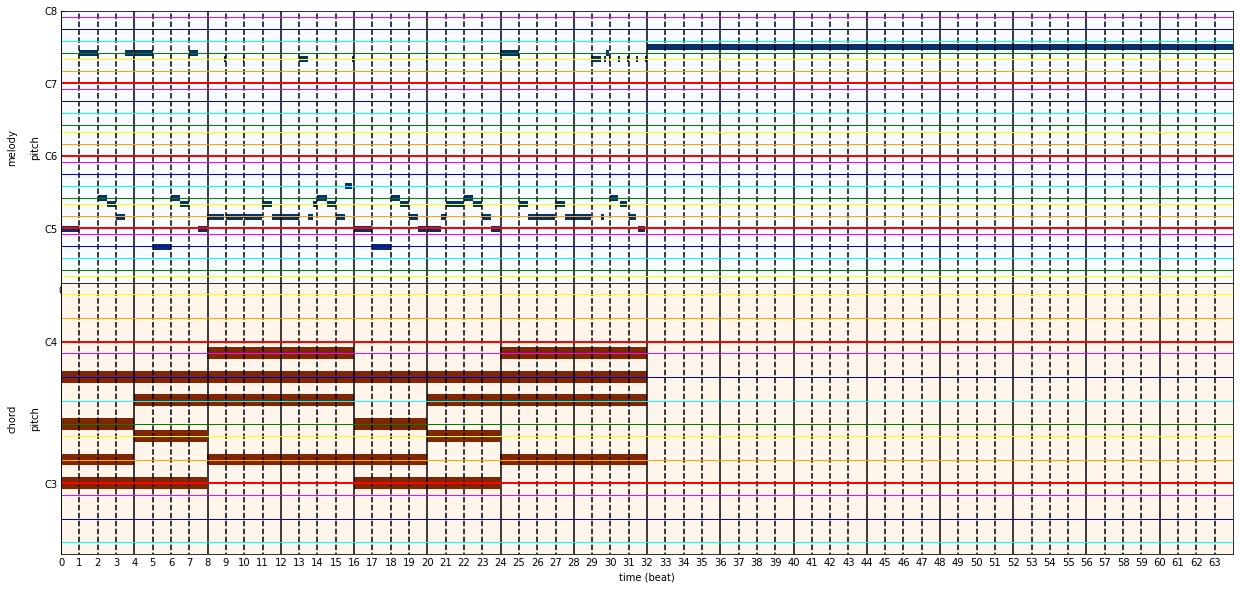

In [12]:
batch_id = 0
bundle = Bundle({
    "melody": batch.melody[batch_id],
    "chord": batch.chord[batch_id],
    "meta": batch.meta[batch_id]
})
bundle.meta.melody_pitch_range = [0, 67]
ppr = bundle.get_ppr()
grid_plot(ppr)

# ConditionalBertBodyの作成
事前学習を行い，他のタスク用モジュールへ連結するためのbodyモジュール  
コードは[ここ](https://nbviewer.jupyter.org/github/fuurin/pytorch_advanced/blob/master/Chapter8/8-2_bert_base.ipynb)を参照

実装するものはこれ  
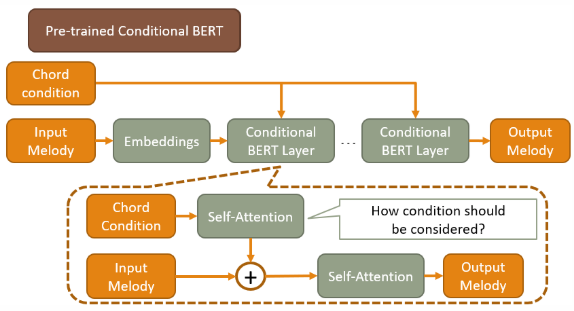

基本となるBERT Layerモジュールはこれ  
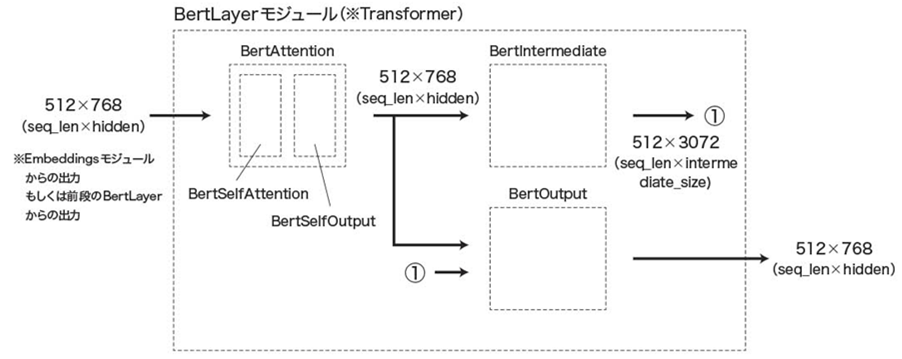

画像： 書籍「つくりながら学ぶ! PyTorchによる発展ディープラーニング」（小川雄太郎、マイナビ出版 、19/07/29)  
公式リポジトリ https://github.com/YutaroOgawa/pytorch_advanced

#### Conditional Bertにするための変更点
ChordConditionをBertAttentionに通した出力をAとする  
AとInputMelodyをBertOutputのような加算＋正規化モジュールへ送った出力をBとする  
BをBertAttentionへ送り，後は同じ  
なお，クラス分類用のPoolerは今回の生成タスクでは使用しないので実装しない  
代わりに小節ごとの情報をまとめるPoolerを作るか？
  
ChordConditionにもEmbedding欲しいかなぁ

## Embeddingsモジュールの実装
- Embeddings
    - MelodyEmbeddings
    - ChordEmbeddings
        - IDで渡ってこないので，EmbeddingsではなくDenseで実装

Embeddingsは意味のある区切りを与えることが多い模様  
それに倣って，音楽版のEmbeddingsは4つで行ってみよう！
- input_embedding: ピッチID/コードベクトルのEmbedding
- step_embedding: range(seq_len)を与えるEmbedding
- beat_embedding: 0から始まる拍番号を各ステップへ与える
- bar_embedding: 0から始まる小節番号を各ステップへ与える

とりあえず埋め込みは学習対象パラメータにする  
埋め込みベクトルのサイズはまず32にしてみる  
モデルが大きいほど事前学習の成果はよくなるみたい

ALBERTのFactorized Embeddingを適用  
埋め込みサイズを一旦小さくし，hidden_sizeへの全結合層で再構成する  
これにより，BERTなら30000 * 1000 = 30M が30000 * 128 + 128 * 1000 = 3Mと大きくパラメータ数を減らせる  
ここでは一旦12へ埋め込んだ後hidden_sizeへ展開する: 633216 -> 76720

In [13]:
def count_params(*modules, requires_grad=True):
    param_nums = []
    for module in modules:
        for param in module.parameters():
            if param.requires_grad and requires_grad:
                param_nums.append(param.numel())
    return sum(param_nums)

count_paramsはutilsへ保存した

In [14]:
class FactorizedEmbedding(nn.Module):
    def __init__(self, vocab_size, fact_size, hidden_size, **kwargs):
        super(FactorizedEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, fact_size, **kwargs)
        self.out = nn.Linear(fact_size, hidden_size, bias=False)
    
    def forward(self, inputs):
        output = self.embedding(inputs)
        output = self.out(output)
        return output

class MusicEmbeddings(nn.Module):
    def __init__(self, config, vocab_size, pad_id=0):
        super(MusicEmbeddings, self).__init__()
        
        # EmbeddingLayer: (入力の種類数, 組込ベクトルサイズ)
        # 48とかのIDを受け取ってone-hot vectorと解釈して組込ベクトルへ変換する
        self.pad_id = pad_id
        self.fact_size = config.fact_size
        self.hidden_size = config.hidden_size
        self.beat_res = config.beat_resolution
        self.step_num = config.step_num
        self.beat_num = config.beats_in_bar * config.bar_num
        self.bar_num = config.bar_num
        self.bar_step_num = config.beats_in_bar * self.beat_res
        
        self.input_embedding = FactorizedEmbedding(
            vocab_size,       # 67 or 4097
            self.fact_size,   # 12
            self.hidden_size, # 24
            padding_idx=pad_id
        )
        
        self.step_embedding = FactorizedEmbedding(
            self.step_num,   # 768
            self.fact_size,  # 12
            self.hidden_size # 24
        )
        
        self.beat_embedding = FactorizedEmbedding(
            self.beat_num,   # 64
            self.fact_size,  # 12
            self.hidden_size # 24
        )
        
        self.bar_embedding = FactorizedEmbedding(
            self.bar_num,    # 16
            self.fact_size,  # 12
            self.hidden_size # 24
        )
        
        self.norm = LayerNorm(config.hidden_size, eps=1e-8)
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def add_fixed_embeddings(self, input_emb):
        # step ID -> ステップ埋め込みベクトル
        step_ids = torch.arange(self.step_num, dtype=torch.float32) # 0~767
        step_ids = step_ids.unsqueeze(0).expand(input_emb.shape[:-1]) # バッチ用の次元を追加
        step_ids = step_ids.to(input_emb.device)
        step_emb = self.step_embedding(step_ids.type(torch.long))
        
        # beat ID -> 拍埋め込みベクトル
        # 同じ数がbeat_res個続くようにする
        beat_ids = torch.floor(step_ids.clone() / self.beat_res)
        beat_emb = self.beat_embedding(beat_ids.type(torch.long))
        
        # bar ID -> 小節埋め込みベクトル
        # 同じ数がbar_step_num個続くようにする
        bar_ids = torch.floor(step_ids.clone() / self.bar_step_num)
        bar_emb = self.bar_embedding(bar_ids.type(torch.long))
        
        # 4つの埋め込みベクトルを足し合わせる
        # (batch_size, step_num, hidden_size)
        embeddings = input_emb + step_emb + beat_emb + bar_emb
        
        return embeddings
    
    def post_layers(self, tensor):
        tensor = self.norm(tensor)
        tensor = self.dropout(tensor)
        return tensor
    
    def forward(self, input_ids):
        # input_ids: (batch_size, step_num)の文章中の単語ID列
        
        # input ID -> 入力埋め込みベクトル
        input_emb = self.input_embedding(input_ids)
        
        # ステップ，拍，小節の埋め込みベクトルを加算
        embeddings = self.add_fixed_embeddings(input_emb)
                
        # 埋め込みベクトルを正規化 & Dropout
        embeddings = self.post_layers(embeddings)
        
        return embeddings

class MelodyEmbeddings(MusicEmbeddings):
    def __init__(self, config):
        super(MelodyEmbeddings, self).__init__(config, config.melody_vocab_size, config.melody_pad_id)

class ChordEmbeddings(MusicEmbeddings):
    def __init__(self, config):
        super(ChordEmbeddings, self).__init__(config, config.chord_vocab_size, config.chord_pad_id)

動作確認

In [15]:
batch = dataloader()

print(batch.melody.shape)
print(batch.chord.shape)

melody_embeddings = MelodyEmbeddings(config)
chord_embeddings = ChordEmbeddings(config)

melody_emb = melody_embeddings(batch.melody)
chord_emb = chord_embeddings(batch.chord)

print("melody_emb shape:", melody_emb.shape)
print("chord_emb shape:", chord_emb.shape)
print("# of parameter(melody + chord):", count_params(melody_embeddings, chord_embeddings))

torch.Size([2, 768])
torch.Size([2, 768])
melody_emb shape: torch.Size([2, 768, 64])
chord_emb shape: torch.Size([2, 768, 64])
# of parameter(melody + chord): 76720


## ConditionalBertAttentionモジュールの実装
以下のサブネットワークを持つ
- ConditionalBertAttention: Conditionを考慮したSelf-Attentionを計算
    - Multi-Head: 1, 2, 4, 8, とりあえず4から試すか
    - ここでpadをかける
- BertIntermediate: Self-Attentionの出力を全結合層で処理
    - 全結合層の活性化関数にGELU（Gaussian error Linear Unit, 入力0付近の出力が滑らか)を使う
- BertOutput: BertAttentionとBertIntermediateの出力を足し算

### ConditionalBertAttentionモジュールの作成
次のサブモジュールからなる
- condition_attn(BertSelfAttention)
- conditioning(BertSelfConditioning, BertSelfOutputとほぼ同じ)
- attn(BertSelfAttention)
- output(BertOutput)

In [16]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        
        self.hidden_size = config.hidden_size # 24
        self.attention_head_num = config.attention_head_num # 4
        self.attention_head_size = self.hidden_size // self.attention_head_num # 6
        
        # Self-Attentionの特徴量を作成する全結合層
        self.query = nn.Linear(self.hidden_size, self.hidden_size)
        self.key = nn.Linear(self.hidden_size, self.hidden_size)
        self.value = nn.Linear(self.hidden_size, self.hidden_size)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def separate_into_heads(self, single):
        # multi-head attention用にテンソルの形を変換
        # [batch, steps, hidden] -> [batch, head_num, steps, head_size]
        multi_shape = single.size()[:-1] + (self.attention_head_num, self.attention_head_size)
        multi = single.view(*multi_shape).permute(0, 2, 1, 3)
        return multi
    
    def extend_pad(self, pad, paded_value=-10000.0):
        # multi-head attention用にpadの形を(batch, 1, 1, step_num)にする
        extended_pad = pad.unsqueeze(1).unsqueeze(2) # multi-headに次元を対応
        extended_pad = (1.0 - extended_pad) * paded_value
        extended_pad = extended_pad.to(dtype=torch.float32)
        return extended_pad
    
    def marge_heads(self, multi):
        # multi-head attentionに分離したテンソルの形を元に戻す
        # [batch, head_num, steps, head_size] -> [batch, steps, hidden]
        multi = multi.permute(0, 2, 1, 3).contiguous()
        single_shape = multi.size()[:-2] + (self.hidden_size,)
        single = multi.view(*single_shape)
        return single
    
    def forward(self, hidden_states, pad, get_probs=False):
        
        # 入力を全結合層で特徴量変換(分岐前)
        marged_query = self.query(hidden_states)
        marged_key = self.key(hidden_states)
        marged_value = self.value(hidden_states)
        
        # multi-head Attentionとして分岐
        queries = self.separate_into_heads(marged_query)
        keys = self.separate_into_heads(marged_key)
        values = self.separate_into_heads(marged_value)
        
        # 特徴量同士の類似度を求める
        scores = torch.matmul(queries, keys.transpose(-1, -2))
        scores = scores / math.sqrt(self.attention_head_size) # Scaled Dot-Product Attention
        
        # マスクをかける
        # 足し算なのは，attention_padに0か-infが入っているため
        # -infはsoftmax正規化したときに0になる
        scores += self.extend_pad(pad)
        
        # AttentionMapの正規化とドロップアウト
        probs = self.softmax(scores)
        attn_map = self.dropout(probs)
        
        # Attenton Mapをvalueに掛け算
        contexts = torch.matmul(attn_map, values)
        
        # multi-head Attentionの出力を結合
        context = self.marge_heads(contexts)
        
        if get_probs:
            return context, probs
        else:
            return context

In [17]:
class BertSelfConditioning(nn.Module):
    def __init__(self, config):
        super(BertSelfConditioning, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.norm = LayerNorm(config.hidden_size, eps=1e-8)
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def forward(self, hidden_states, condition_tensor):
        conditioned_states = self.dense(hidden_states + condition_tensor)
        conditioned_states = self.dropout(conditioned_states)
        conditioned_states = self.norm(conditioned_states)
        return conditioned_states

In [18]:
class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.norm = LayerNorm(config.hidden_size, eps=1e-8)
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.norm(hidden_states + input_tensor)
        return hidden_states

In [19]:
class ConditionalBertAttention(nn.Module):
    def __init__(self, config):
        super(ConditionalBertAttention, self).__init__()
        self.condition_attn = BertSelfAttention(config)
        self.conditioning = BertSelfConditioning(config)
        self.attn = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, condition_tensor, input_pad, condition_pad, get_probs=False):
        reporter = MemReporter(self.attn)
        if get_probs:
            condition, condition_probs = self.condition_attn(condition_tensor, condition_pad, get_probs)
            conditioned_tensor = self.conditioning(input_tensor, condition)
            output, probs = self.attn(conditioned_tensor, input_pad, get_probs)
            output = self.output(output, input_tensor) # or conditioned_tensor?
            print(reporter.report())
            return output, probs, condition_probs
        else:
            condition = self.condition_attn(condition_tensor, condition_pad, get_probs)
            conditioned_tensor = self.conditioning(input_tensor, condition)
            output = self.attn(conditioned_tensor, input_pad, get_probs)
            output = self.output(output, input_tensor) # or conditioned_tensor?
            print(reporter.report())
            return output

In [20]:
def make_pad(ids, pad_id):
    return (ids != pad_id).to(torch.float32)

動作確認

In [21]:
device = torch.device('cpu')
batch = dataloader()
batch.melody = batch.melody.to(device)
batch.chord = batch.chord.to(device)

print(batch.melody.shape)
print(batch.chord.shape)

melody_pad = make_pad(batch.melody, config.melody_pad_id).to(device)
chord_pad = make_pad(batch.chord, config.chord_pad_id).to(device)

melody_embeddings = MelodyEmbeddings(config).to(device)
chord_embeddings = ChordEmbeddings(config).to(device)
attention = ConditionalBertAttention(config).to(device)

melody_emb = melody_embeddings(batch.melody)
chord_emb = chord_embeddings(batch.chord)

get_probs=False
if get_probs:
    output, probs, c_probs = attention(melody_emb, chord_emb, melody_pad, chord_pad, get_probs=get_probs)
    print("output shape:", output.shape)
    print("probs shape:", probs.shape)
    print("conditional probs shape:", c_probs.shape)
else:
    output = attention(melody_emb, chord_emb, melody_pad, chord_pad, get_probs=get_probs)
    print("output shape:", output.shape)

torch.Size([2, 768])
torch.Size([2, 768])


/root/schwbert/.venv/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Element type                                            Size  Used MEM
-------------------------------------------------------------------------------
Storage on cpu
Parameter0                                          (64, 64)    16.00K
Parameter1                                             (64,)   512.00B
Parameter2                                             (64,)   512.00B
Parameter3                                             (64,)   512.00B
Tensor4                                         (2, 768, 64)   384.00K
Tensor5                                         (2, 768, 64)   384.00K
Tensor6                                         (2, 768, 64)   384.00K
Tensor7                                         (2, 768, 64)   384.00K
Tensor8                                         (2, 768, 64)   384.00K
Tensor9                                             (2, 768)     6.00K
Tensor10                                            (2, 768)     6.00K
Tensor11                                            (

### BertIntermediateモジュールの実装

In [67]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [68]:
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = gelu
    
    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

### BertOutputモジュールの実装

In [69]:
class BertOutput(BertSelfOutput):
    def __init__(self, config):
        super(BertOutput, self).__init__(config)        
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)

### ConditionalBertLayerモジュールの実装

In [70]:
class ConditionalBertLayer(nn.Module):
    def __init__(self, config):
        super(ConditionalBertLayer, self).__init__()
        self.attn = ConditionalBertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)
    
    def forward(self, input_tensor, condition_tensor, input_pad, condition_pad, get_probs=False):
        if get_probs:
            output, probs, c_probs = self.attn(input_tensor, condition_tensor, input_pad, condition_pad, get_probs)
            intermediate_output = self.intermediate(output)
            output = self.output(intermediate_output, output)
            return output, probs, c_probs
        else:
            output = self.attn(input_tensor, condition_tensor, input_pad, condition_pad, get_probs)
            intermediate_output = self.intermediate(output)
            output = self.output(intermediate_output, output)
            return output

### ConditionalBertStackモジュールの実装
Embeddingとは分離してパラメータを保存したいため，Stackの部分をモジュール化  
padはidsからつくるため，bodyで作る

In [71]:
class ConditionalBertStack(nn.Module):
    def __init__(self, config):
        super(ConditionalBertStack, self).__init__()
        self.layer_num = config.attention_layer_num    
        self.share_all_params = config.get("share_all_bert_params", False)
        if self.share_all_params:
            self.shared_attention = ConditionalBertLayer(config)
            self.attention_list = range(self.layer_num)
        else:
            attention_list = [ConditionalBertLayer(config) for _ in range(self.layer_num)]
            self.attention_list = nn.ModuleList(attention_list)
    
    def forward(self, input_tensor, condition_tensor, input_pad, condition_pad, 
                get_all_outputs=False, get_probs=False):
        
        all_outputs, all_probs, all_c_probs = [], [], []
        
        for attention in self.attention_list:
            if self.share_all_params:
                attention = self.shared_attention
                
            if get_probs:
                input_tensor, probs, c_probs = attention(
                    input_tensor, condition_tensor, 
                    input_pad, condition_pad, 
                    get_probs=get_probs)
            else:
                input_tensor = attention(
                    input_tensor, condition_tensor, 
                    input_pad, condition_pad, 
                    get_probs=get_probs)
                
            # 12段すべての出力を見る場合
            if get_all_outputs:
                all_outputs.append(input_tensor)
                if get_probs:
                    all_probs.append(probs)
                    all_c_probs.append(c_probs)
                
        # 最終段のAttentionのみ必要な場合
        if not get_all_outputs:
            all_outputs = input_tensor
            if get_probs:
                all_probs = probs
                all_c_probs = c_probs
        
        if get_probs:
            return (all_outputs, all_probs, all_c_probs)
        else:
            return all_outputs

## ConditionalBertBodyの実装
embeddingsはあとでノイズ発生器に置き換えたりできるのでattention_listとは別に保存できるようにする

In [72]:
class ConditionalBertBody(nn.Module):
    def __init__(self, config, input_embeddings, condition_embeddings):
        super(ConditionalBertBody, self).__init__()
        self.config = config
        self.input_pad_id = input_embeddings.pad_id
        self.condition_pad_id = condition_embeddings.pad_id
        self.input_embeddings = input_embeddings
        self.condition_embeddings = condition_embeddings
        self.conditional_bert_stack = ConditionalBertStack(config)
    
    def make_pad(self, input_tensor, pad_id):
        if input_tensor.dim() == 2:
            pad = (input_tensor != pad_id)
        elif input_tensor.dim() == 3:
            pad = (input_tensor[:, :, pad_id] == 1)
        
        pad = pad.to(torch.float32).to(input_tensor.device)
        return pad
    
    def forward(self, input_tensor, condition_tensor, get_all_outputs=False, get_probs=False):
        input_pad = self.make_pad(input_tensor, self.input_pad_id)
        condition_pad = self.make_pad(condition_tensor, self.condition_pad_id)
        input_tensor = self.input_embeddings(input_tensor)
        condition_tensor = self.condition_embeddings(condition_tensor)
        stack_out = self.conditional_bert_stack(
                        input_tensor, condition_tensor,
                        input_pad, condition_pad,
                        get_all_outputs, get_probs)
        return stack_out

In [73]:
class MultiGPUWrapper:
    """
    DataParallelでWrapしてもmoduleのアトリビュートにアクセスできるWrapper
    DataParallelへのアトリビュートアクセスが優先され，なければmoduleのものにアクセスする
    dirなど中身を見たいときにはthis.moduleもしくはthis.data_parallelを用いる
    """
    def __init__(self, module, device_ids=None, output_device=None, dim=0):
        self.module = module
        self.data_parallel = nn.DataParallel(self.module, device_ids, output_device, dim)
        
    def __getattr__(self, attr):
        if hasattr(self.data_parallel, attr):
            return getattr(self.data_parallel, attr)
        else:
            return getattr(self.module, attr)
    
    def __call__(self, *args, **kwargs):
        return self.data_parallel(*args, **kwargs)

ここまでのモデル定義はmodel.pyからimportできるようにした

動作確認

In [74]:
# device = torch.device("cuda:2")
device = torch.device("cpu")

batch = dataloader()
batch.melody = batch.melody.to(device)
batch.chord = batch.chord.to(device)
print(batch.melody.shape)
print(batch.chord.shape)

melody_emb = MelodyEmbeddings(config)
chord_emb = ChordEmbeddings(config)
body = ConditionalBertBody(config, melody_emb, chord_emb)
body = body.to(device)

# お手軽マルチGPU
# deviceは今まで通りっぽい
# だが，DataParallelクラスにラップされているので，モジュールにアクセスするにはbody.moduleを呼ぶ
# body = MultiGPUWrapper(body, device_ids=[2,3])

get_probs = True
get_all_outputs = True
if get_probs:
    output, probs, c_probs = body(batch.melody, batch.chord, get_all_outputs, get_probs)
    if get_all_outputs:
        print("output len:", len(output))
        print("probs len:", len(probs))
        print("conditional probs len:", len(c_probs))
    print("output shape:", (output[0] if get_all_outputs else output).shape)
    print("probs shape:", (probs[0] if get_all_outputs else probs).shape)
    print("conditional probs shape:", (c_probs[0] if get_all_outputs else c_probs).shape)
else:
    output = body(batch.melody, batch.chord, get_all_outputs, get_probs)
    if get_all_outputs:
        print("output len:", len(output))
    print("output shape:", (output[0] if get_all_outputs else output).shape)

torch.Size([2, 768])
torch.Size([2, 768])
output len: 8
probs len: 8
conditional probs len: 8
output shape: torch.Size([2, 768, 64])
probs shape: torch.Size([2, 8, 768, 768])
conditional probs shape: torch.Size([2, 8, 768, 768])


bodyのパラメータ数を確認してみる  
1176320 -> factorized embeddings -> 877744 -> share all bert params -> 143472  
これによりhidden_sizeを爆増させられるようになり，256にしてみると -> 1149360 と，ほぼ元のパラメータ数に戻った  
しかしそれだとなんだかGPU増やしてもメモリ不足になるのでhiddenを100にし，242220というパラメータ数になった

In [75]:
print("trainable params:", count_params(body))
# print(body)

trainable params: 143472


# 事前学習フレームワークと各事前学習モジュールの作成

## 事前学習フレームワークの作成
事前学習フレームワークは以下の動作が主な役割である
- body,DataLoader,事前学習クラスのリストを渡す
    - 入力データとラベルの作成
    - bodyと事前学習モジュールを連結
    - 入力データを連結モジュールへ与える
    - 出力とラベルからロスをBP

事前学習クラスは以下を持つ
- 入力データとラベルの作成関数
- 事前学習モジュールの定義関数
- 損失関数

In [76]:
class PreTrainingModel(nn.Module):
    def __init__(self, config, body):
        super(PreTrainingModel, self).__init__()
        self.config = config
        self.body = body
        self.loss_dict = {'train': [], 'val': []}
        self.acc_dict = {'train': [], 'val': []}
    
    def forward(self, batch):
        body_output = self.body(batch.melody, batch.chord)
        head_output = self.forward_head(batch, body_output)
        return head_output
    
    def send(self, batch, device):
        raise NotImplementedError()
    
    def forward_head(self, batch, body_output):
        raise NotImplementedError()
    
    def get_loss_and_acc(self, batch, model_output):
        raise NotImplementedError()
    
    @property
    def condition_str(self):
        raise NotImplementedError()
    
    @property
    def name(self):
        return self.__class__.__name__

## 各事前学習クラスの作成
事前学習はひとまず3種類
- Masked Note Prediction (虫食い音符の穴埋め)
    - 1ステップごとではなく，音符一つごとMASKして穴埋め
    - 休符も1つの音符と数えるべき？
    - ランダムに入れ替えたり，そのままにしたりするのを1割ずつやる
- Bars Order Prediction (小節の順番を学習)
    - 全ての小節をバラバラにして元の楽曲を生成
    - 16 × 16の行列を出力させ，どの小節が何番目にあるべきかを推論
- (Chord) Condition Prediction (元のコード条件を出力メロディから推論)
    - chord ID を出力メロディから推論
    - Chordにカッコがついてるのは，テンポやジャンルといった条件が増えたときにも同様の事前学習をさせられるため

### MaskedNotePredictionの作成
音符単位でマスクしてマスクされている部分を推測する  
[MASK]トークンはファインチューニングの際には出現しないためミスマッチを作ってしまうという弱点がある．  
そこで，マスク対象となった単語を実際の[MASK]には，必ずしも置き換えないことにする．  
  
訓練データ生成器は推論に用いる全体の15%のトークンポジションをランダムに選ぶ．  
$i$番目のトークンが選ばれたとき，$i$番目のトークンを
- (1) 80%の確立で[MASK]に置き換える
- (2) 10%の確立で別のランダムな単語に置き換える
- (3) 10%の確立でそのままのトークンにしておく
    
そして，$i$番目のトークン$T_i$はオリジナルのトークンの推測に使用され，cross entropy lossで損失を得る  
  
衝撃の事実: 事前学習用のデータは固定で，イテレーションの度にマスクされる場所が変更されるわけではなかった  
今回扱うデータは自然言語並みに多様性があるわけではないのでイテレーションの度に変更するようにしてみる

とりあえず全結合2段でMNPしてみよう

マスクされるpositionの数はbundleによってまちまちである  
bertの本家コードでは，max_predictions_per_seqを導入し，この数を超えないようにtokensを選ぶ  
そして，max_predictions_per_seqに満たない部分はposition=0, id=0, weight=0とし，paddingする  
これにより，mwpヘッドへの入力をmax_predictions_per_seq個のトークンに絞る．  
padされているpositionのlossにweight=0をかけてやることで  
上記の処理でマスクされるpositionのみのlossとaccを求める  
コードは本家の[run_pretraining.py](https://github.com/google-research/bert/blob/e13c1f3459cc254f7abbabfc5a286a3304d573e4/run_pretraining.py#L277)及び[create_pretraining_data.py](https://github.com/google-research/bert/blob/0fce551b55caabcfba52c61e18f34b541aef186a/create_pretraining_data.py#L125)が参考になる

In [77]:
class MaskedNotePrediction(PreTrainingModel):
    def __init__(self, config, body, include_rest=True):
        super(MaskedNotePrediction, self).__init__(config, body)
        self.hidden_size = config.hidden_size
        
        self.dense_1 = nn.Linear(config.hidden_size, config.hidden_size)
        self.act_1 = gelu
        self.norm_1 = LayerNorm(config.hidden_size, eps=1e-8)
        self.dense_2 = nn.Linear(config.hidden_size, config.melody_vocab_size)
        self.act_2 = gelu
        self.norm_2 = LayerNorm(config.melody_vocab_size, eps=1e-8)
        self.log_softmax = nn.LogSoftmax(dim=0)
    
    def send(self, batch, device):
        batch.melody = batch.melody.to(device)
        batch.chord = batch.chord.to(device)
        batch.mnp_steps = batch.mnp_steps.to(device)
        batch.mnp_weights = batch.mnp_weights.to(device)
        batch.mnp_labels = batch.mnp_labels.to(device)
        return batch
    
    def forward_head(self, batch, body_output):
        # ここでloss計算対象ステップを絞る．
        # body_outputはすでに周囲の情報を考慮しており，
        # 以降のDenseではステップごとに同じ処理が行われるため，
        # targetでない入力を使う必要がない
        # body_output: [2, 765, 24], batch_steps(index): [2, 115, 24], gatherのoutput: [2, 115, 24]
        batch_steps = batch.mnp_steps.unsqueeze(-1).expand(-1, -1, self.hidden_size)
        output = torch.gather(body_output, 1, batch_steps)
        output = self.dense_1(output)
        output = self.act_1(output)
        output = self.norm_1(output)
        output = self.dense_2(output)
        output = self.act_2(output)
        output = self.norm_2(output)
        return output
        
    def get_loss_and_acc(self, batch, model_output, eps=1e-8):
        # トークンごとに対象かどうかをweightで選択し，CrossEntropyを求める
        # PytorchのCrossEntropyLossではこれができなそうなので，本家コードに従った処理を行う
        softmax_out = self.log_softmax(model_output)
        weighted_ce_loss = softmax_out * batch.mnp_labels * batch.mnp_weights
        neg_sum_loss = - weighted_ce_loss.sum()
        target_seq_len = batch.mnp_weights.sum()
        avg_loss = neg_sum_loss / (target_seq_len + eps)
        
        # model_outputの最大値とlabelからaccuracyを求める
        probs, preds = torch.max(model_output, dim=-1)
        ones, label_ids = torch.max(batch.mnp_labels, dim=-1)
        weighted_corrects = (preds == label_ids) * batch.mnp_weights.squeeze()
        correct_num = weighted_corrects.sum().to(torch.float)
        avg_acc = correct_num / (target_seq_len + eps)
        
        return avg_loss, avg_acc
    
    @property
    def condition_str(self):
        A = self.config.pre_mnp_aug
        T = self.config.pre_mnp_rate
        M = self.config.pre_mnp_mask_rate
        R = self.config.pre_mnp_random_rate
        K = self.config.pre_mnp_keep_rate
        return f"MNP:A={A}T={T}M={M}R={R}K={K}"

動作確認

In [78]:
device = torch.device('cpu')

mnp = MaskedNotePrediction(config, body)
mnp = mnp.to(device)
# mnp = MultiGPUWrapper(mnp, device_ids=[2,3])

with Timer():
    batch = dataloader()
    batch = mnp.send(batch, device)
    output = mnp(batch)
    loss, acc = mnp.get_loss_and_acc(batch, output)

print(loss, acc)

0.654282
tensor(0.6945, grad_fn=<DivBackward0>) tensor(0.0387)


### BarsOrderPredictionの作成

GANによる学習を優先

### ConditionPredictionの作成

GANによる学習を優先

# 事前学習の実行と結果の表示・保存

## モデルとconfigの保存・読込用関数を作成  
学習中に一定エポックごとに保存したいので先にこの作業をやってしまう  
あとでmelody_embはノイズ発生器に置き換えたいのでsave_bodyはembとattention_listを別々に保存する

In [34]:
def make_state_name(config, model, epoch_num):
    if issubclass(model.__class__, PreTrainingModel):
        model_name = model.name
    elif issubclass(model.__class__, MultiGPUWrapper):
        model_name = model.module.__class__.__name__
    else:
        model_name = model.__class__.__name__
    
    nickname = config.nickname
    E = epoch_num
    H = config.hidden_size
    I = config.intermediate_size
    A = config.attention_layer_num
    AH = config.attention_head_num
    
    state_name = f"{nickname}:{model_name}:E={E:0>3}H={H}I={I}A={A}AH={AH}"
    
    if issubclass(model.__class__, PreTrainingModel):
        state_name += model.condition_str
    
    return state_name

def save_model(config, model, epoch_num, directory):
    if issubclass(model.__class__, MultiGPUWrapper):
        model = model.module
    
    state_name = f"{make_state_name(config, model, epoch_num)}.pth"
    state_path = os.path.join(directory, state_name)
    torch.save(model.state_dict(), state_path)
    print(f"{state_name} saved")
    return state_name

def load_model(model, state_name, directory):
    file_path = os.path.join(directory, state_name)
    state_dict = torch.load(file_path)
    model.load_state_dict(state_dict)
    return model

def save_body(config, body, epoch_num, directory):
    input_emb_name = save_model(config, body.input_embeddings, epoch_num, output_dir)
    condition_emb_name = save_model(config, body.condition_embeddings, epoch_num, output_dir)
    bert_stack_name = save_model(config, body.conditional_bert_stack, epoch_num, output_dir)
    return AttrDict({
        "input_embeddings": input_emb_name, 
        "condition_embeddings": condition_emb_name, 
        "conditional_bert_stack": bert_stack_name
    })

def load_body(config, input_emb, condition_emb, directory):
    state_name_dict = config["state_names"]
    
    input_emb_name = state_name_dict['input_embeddings']
    condition_emb_name = state_name_dict['condition_embeddings']
    bert_stack_name = state_name_dict['conditional_bert_stack']
    
    input_emb = load_model(input_emb, input_emb_name, directory)
    condition_emb = load_model(condition_emb, condition_emb_name, directory)
    body = ConditionalBertBody(config, melody_emb, chord_emb)
    body.conditional_bert_stack = load_model(body.conditional_bert_stack, 
                                             bert_stack_name, directory)
    
    return body

def save_config(config, directory, state_names_dict={}):
    delta = datetime.timezone(datetime.timedelta(hours=9))
    now = datetime.datetime.now(delta).strftime('%Y-%m-%d_%H:%M')
    file_name = f"{config.nickname}:config@{now}.json"
    file_path = os.path.join(directory, file_name)
    config['state_names'] = dict(state_names_dict)
    json.dump(dict(config), 
              open(file_path, "w"), 
              ensure_ascii=False, 
              indent=4, 
              separators=(',', ': '))
    print(f"{file_name} saved")
    return file_name

def load_config(config_name, directory):
    file_path = os.path.join(directory, config_name)
    config = AttrDict(json.load(open(file_path, "r")))
    return config

動作確認

save_model(config, mnp, 0, output_dir)  
state_names_dict = save_body(config, body, 0, output_dir)  
config_path = save_config(config, output_dir, state_names_dict=state_names_dict)  
body_trained = load_body(config, MelodyEmbeddings(config), ChordEmbeddings(config), output_dir)

## 事前学習

### DataLoaderを作成

In [35]:
batch_size = 3
dataloaders_dict = {
    'train': TheorytabDataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': TheorytabDataLoader(val_dataset, batch_size=batch_size, shuffle=True),
    'test': TheorytabDataLoader(test_dataset, batch_size=batch_size/2)
}
print(f"train data size: {len(dataloaders_dict['train'].dataset):<5}, batch num: {len(dataloaders_dict['train']):<5}")
print(f"  val data size: {len(dataloaders_dict['val'].dataset):<5}, batch num: {len(dataloaders_dict['val']):<5}")
print(f" test data size: {len(dataloaders_dict['test'].dataset):<5}, batch num: {len(dataloaders_dict['test']):<5}")

train data size: 41750, batch num: 13917
  val data size: 8871 , batch num: 2957 
 test data size: 1567 , batch num: 1045 


### モデルの用意

In [36]:
device = torch.device('cuda')
multi_gpu = (visible_devices != []) & (device.type == 'cuda')

melody_emb = MelodyEmbeddings(config)
chord_emb = ChordEmbeddings(config)
body = ConditionalBertBody(config, melody_emb, chord_emb)
pre_training_models = [
    MaskedNotePrediction(config, body).to(device),
    # BarsOrderPrediction(config, body).to(device),
    # ConditionPrediction(config, body).to(device),
]

if multi_gpu:
    print("Use Multi GPUs")
    ids = list(range(len(visible_devices)))
    pre_training_models = [MultiGPUWrapper(model, device_ids=ids) for model in pre_training_models]

optimizer = optim.Adam([
    {'params': model.parameters(), 'lr': config.adam_lr} for model in pre_training_models
], betas = (config.adam_beta1, config.adam_beta2))

print("Network settings completed")

Use Multi GPUs
Network settings completed


### 事前学習の実行

In [37]:
def pre_train(body, pre_training_models, dataloaders_dict, optimizer, epoch_num, output_dir, device,
              start_epoch=1, report_period=50, save_epoch_period=5, clear_disp_epoch_period=3): 
    torch.backends.cudnn.benchmark = True
    
    if start_epoch < 2:
        for model in pre_training_models:
            for phase in ['train', 'val']:
                model.loss_dict[phase] = []
                model.acc_dict[phase] = []
    try:
        for epoch in range(start_epoch, epoch_num+1):
            if (epoch-1) % clear_disp_epoch_period == 0:
                clear_output()

            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()

            for model in pre_training_models:
                print(f"----- Pre-training task start -----")
                print(f"Pre-training model: {model.name}")
                t_model_start = time.time()

                for phase in ['train', 'val']:
                    if phase == 'train':
                        model.train()
                    else:
                        model.eval()
                        print("\nValidating...")

                    model_loss = 0.0
                    model_acc = 0.0

                    t_iter_start = time.time()
                    batch_num = len(dataloaders_dict[phase])
                    for iteration, batch in enumerate(dataloaders_dict[phase], 1):
                        optimizer.zero_grad()
                        with torch.set_grad_enabled(phase == 'train'):
                            batch = mnp.send(batch, device)
                            output = model(batch)
                            loss, acc = model.get_loss_and_acc(batch, output)
                            
                            model_loss += loss.item()
                            model_acc += acc.item()

                            if phase == 'train':
                                loss.backward()
                                optimizer.step()
                                if (iteration % report_period == 0):
                                    duration = time.time() - t_iter_start
                                    print(f"Iteration {iteration:>5}/{batch_num:<5} | Loss: {loss:.4f} | Acc: {acc:.4f} | {duration:.4f}[sec]")
                                    t_iter_start = time.time()

                    model_loss /= batch_num
                    model_acc /= batch_num
                    model.loss_dict[phase].append(model_loss)
                    model.acc_dict[phase].append(model_acc)

                    print(f"Average result of {model.__class__.__name__} in {phase:^5} phase")
                    print(f"Epoch {epoch:>3} / {epoch_num:<3} | Loss: {model_loss:.4f} | Acc: {model_acc:.4f}")

                print(f"\nPre-training epoch finished in {time.time() - t_model_start:.4f}[sec]\n")

            epoch_duration = time.time() - t_epoch_start
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]\n")

            # チェックポイントモデルの保存
            if (epoch % save_epoch_period == 0):
                print("start saving models")
                save_body(config, body, epoch, output_dir)
                for model in pre_training_models:
                    save_model(config, model, epoch, output_dir)
                print("")

        print("All Pre-training Finished!")
    
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        return body, pre_training_models
    
    return body, pre_training_models

In [ ]:
epoch_num = 10
body_trained, models_trained = pre_train(
    body=body,
    pre_training_models=pre_training_models,
    dataloaders_dict=dataloaders_dict,
    optimizer=optimizer,
    epoch_num=epoch_num,
    output_dir=output_dir,
    device=device,
    start_epoch=1,
    report_period=len(dataloaders_dict['train']) // 10,
    save_epoch_period = 5
)

----- Epoch   1 / 10  start -----
----- Pre-training task start -----
Pre-training model: MaskedNotePrediction


## 事前学習結果の表示

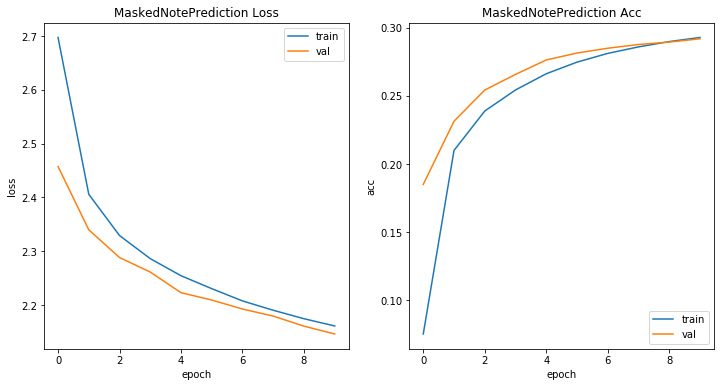

In [41]:
task_num = len(models_trained)
fig, axs = plt.subplots(task_num, 2, figsize=(12, task_num*6))

for m, model in enumerate(models_trained):
    train_loss = model.loss_dict['train']
    val_loss = model.loss_dict['val']
    train_acc = model.acc_dict['train']
    val_acc = model.acc_dict['val']
    x = np.arange(len(train_loss))
    
    if task_num == 1:
        ax_loss = axs[0]
        ax_acc = axs[1]
    else:
        ax_loss = axs[m][0]
        ax_acc = axs[m][1]
        
    ax_loss.plot(x, train_loss, label='train', linewidth=1.5)
    ax_loss.plot(x, val_loss, label='val', linewidth=1.5)
    ax_loss.legend(loc='upper right')
    ax_loss.set_xlabel('epoch')
    ax_loss.set_ylabel('loss')
    ax_loss.set_title(f"{model.name} Loss")

    ax_acc.plot(x, train_acc, label='train', linewidth=1.5)
    ax_acc.plot(x, val_acc, label='val', linewidth=1.5)
    ax_acc.legend(loc='lower right')
    ax_acc.set_xlabel('epoch')
    ax_acc.set_ylabel('acc')
    ax_acc.set_title(f"{model.name} Acc")

plt.show()

MaskedNotePrediction:E=100H=64I=256A=12AH=8MNP:T=0.15M=0.8R=0.1K=0.1の学習結果  
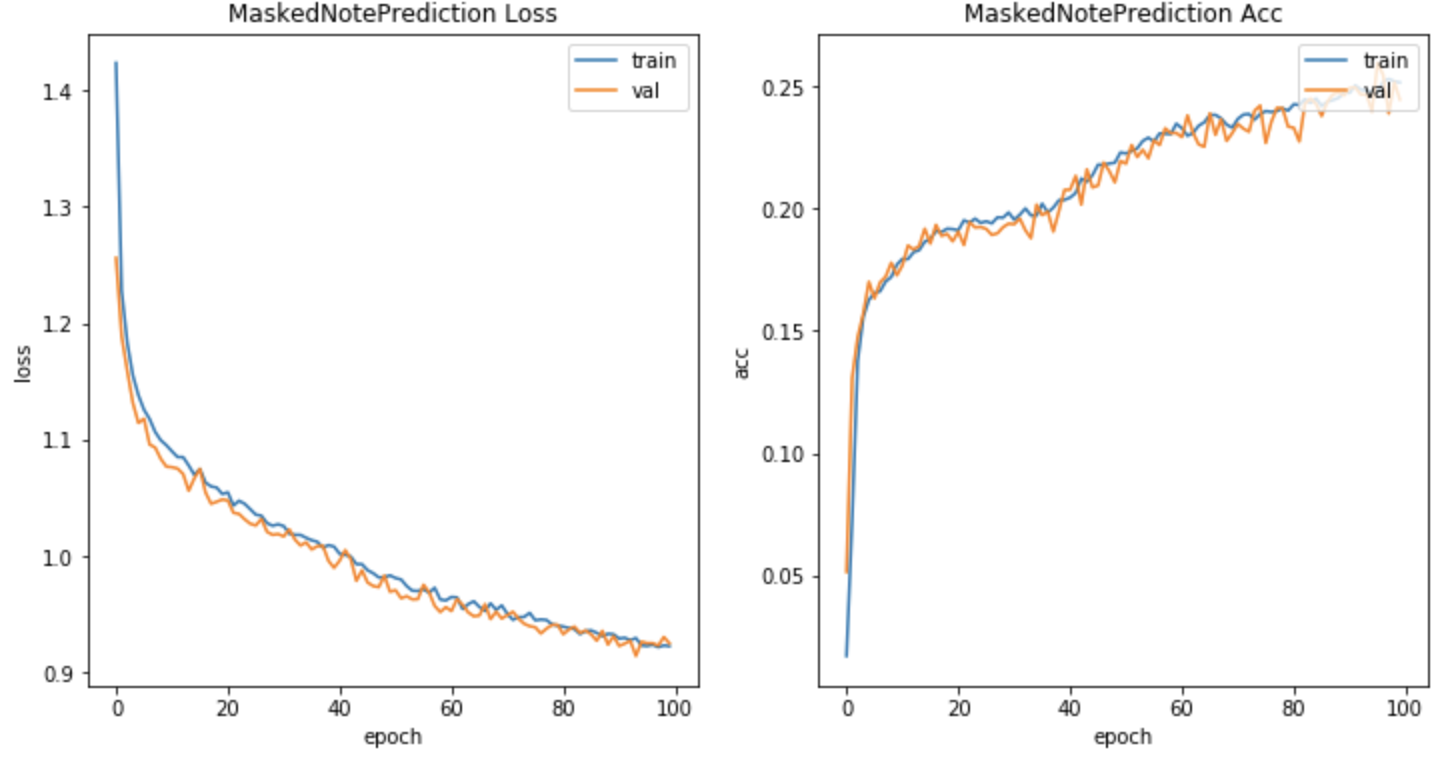

Factorized EmbeddingsとWeight Sharingを用いた結果，短いエポックで同等の性能を達成  
なお，学習データは毎回新しいマスクを作るのではなく，固定のマスク済みデータを3つ用意して利用した  
しかしそれでも25%未満の正答率にとどまる
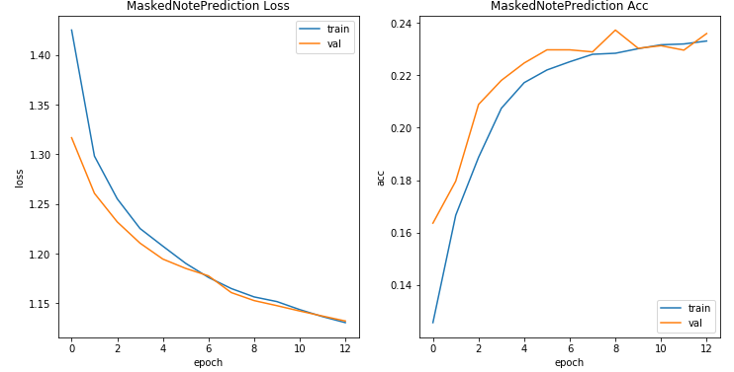

Weight Sharingをやめた結果．(モデルサイズは同じサイズだとGPUに乗らないので小さくなってしまっている)    
テストも21%程度  
Weight Sharing＋モデル大型化した方が精度高いし，圧倒的に軽い．  
これからはALBERTで行こうと思う
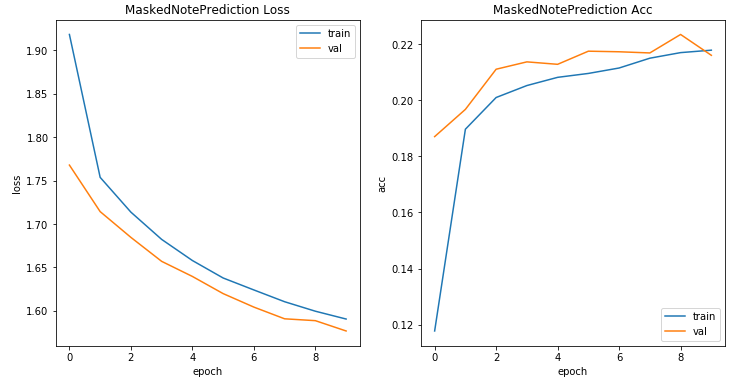

ALBERTのモデルを小さくしたもの  
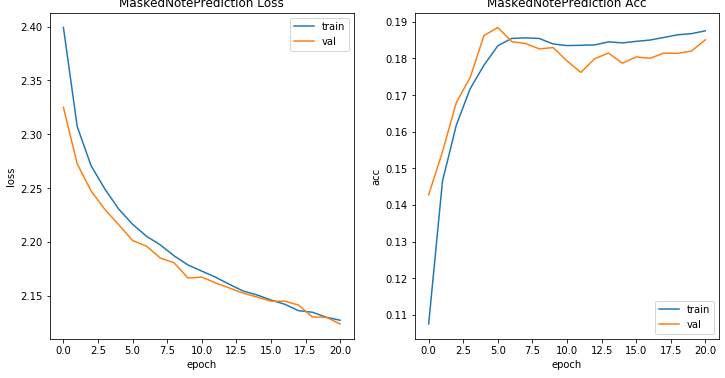  
これはもしかして勾配消失？と思い，BERTレイヤの層を減らしてみたが，性能はあまり上がらなかった

結局，パラメータではどうにもならなそう．  
LossとACCの計算を見直し，それからタスクの見直しを行う

## 事前学習済みモデルの保存と読込み

In [42]:
state_names_dict = save_body(config, body_trained, epoch_num, output_dir)

pre_training_state_names = []
for model_trained in models_trained:
    state_name = save_model(config, model_trained, epoch_num, output_dir)
    pre_training_state_names.append(state_name)

state_names_dict['masked_note_prediction'] = pre_training_state_names[0]

config_file_name = save_config(config, output_dir, state_names_dict=state_names_dict)

albert_base:MelodyEmbeddings:E=010H=64I=256A=12AH=4.pth saved
albert_base:ChordEmbeddings:E=010H=64I=256A=12AH=4.pth saved
albert_base:ConditionalBertStack:E=010H=64I=256A=12AH=4.pth saved
albert_base:MaskedNotePrediction:E=010H=64I=256A=12AH=4MNP:A=3T=0.15M=0.8R=0.1K=0.1.pth saved
albert_base:config@2019-11-14_19:13.json saved


In [41]:
config = load_config(config_file_name, directory)

body_trained = load_body(config, MelodyEmbeddings(config), ChordEmbeddings(config), directory)

models_trained = [
    load_model(
        MaskedNotePrediction(config, body_trained), 
        config.state_names.masked_note_prediction,
        output_dir),
]

## テストデータでのチェック

In [42]:
model = models_trained[0]

device = torch.device("cuda:2")
model = model.to(device)
# model = MultiGPUWrapper(model, device_ids=[2,3])

print(f"Start task using test data by {model.name}")
with Timer():
    test_acc = 0.
    model.eval()
    for batch in dataloaders_dict['test']:
        
        with torch.set_grad_enabled(False):
            batch = model.send(batch, device)
            output = model(batch)
            
            # 評価モード時はlossが出ない．たぶん．
            _, acc = model.get_loss_and_acc(batch, output)
            test_acc += acc

data_num = len(dataloaders_dict['test'].dataset)
batch_num = len(dataloaders_dict['test'])
test_acc /= batch_num

print(f"Accuracy result by {data_num} test data: {test_acc}")

Start task using test data by MaskedNotePrediction
128.129836
Accuracy result by 1567 test data: 0.21470949053764343
